In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import glob
from tqdm import notebook
import seaborn as sns
# matplotlib.rc('text', usetex = True)


In [12]:
exp_dir = "/media/user/nvme/contrastive_experiments/experiments_speech_commands_layerwise_latest/"

In [13]:
def ckpt_info(f):
    # print(f)
    # val_acc = float(f.split("/")[-1].replace(".pth", "").split("val_acc=")[-1])
    val_acc = torch.load(f)['val_acc']
    #print(val_acc)
    fconly = "_fconly_" in f
    is_contrastive = "_constrastive_" in f
    if is_contrastive:
        model_type = "Contrastive"
    else:
        model_type = 'Supervised'
    if fconly:
        model_type_alt = model_type+",fconly"
    else:
        model_type_alt = model_type+",full"
    #print(fconly, is_contrastive)
    res = {
        "val_acc" : val_acc,
        "fconly": fconly,
        "model_type": model_type,
        "layer": int(f.split("/")[-4].replace("layer","")),
        "model_type_alt": model_type_alt,
        "ckpt_ext": "/".join(f.split("/")[-4:])
    }
    return res

In [14]:
def get_model_info(model_dir):
    ckpt = glob.glob(os.path.join(model_dir, "ckpts", "*"))[0]
    
    #print(ckpt)
    return ckpt_info(ckpt)

In [24]:
records = []
for i in notebook.tqdm(range(1, 12)):
    layer_dir = os.path.join(exp_dir, f"layer{i}")
    # print(layer_dir)
    models = glob.glob(os.path.join(layer_dir, "*"))
    # print(models)
    for mod in models:
        rec = get_model_info(mod)
        records.append(rec)

  0%|          | 0/11 [00:00<?, ?it/s]

In [25]:
records.append({"val_acc": 0.7710, "fconly": False, "model_type_alt": "Supervised,full", "layer": 5, "model_type": "Supervised", "ckpt_ext":"unknown.pth"})

In [26]:
df = pd.DataFrame.from_records(records)

In [27]:
df_fconly_contrastive = df[df['model_type_alt'] == "Contrastive,fconly"]
df_fconly_supervised = df[df['model_type_alt'] == "Supervised,fconly"]
df_full_contrastive = df[df['model_type_alt'] == "Contrastive,full"]
df_full_supervised = df[df['model_type_alt'] == "Supervised,full"]

In [28]:
df_final = df_fconly_contrastive.append(df_fconly_supervised).append(df_full_contrastive).append(df_full_supervised)

In [30]:
import seaborn as sns

In [31]:
colours = sns.color_palette("deep", 4)

In [32]:
colours

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]

In [33]:
import torch

In [34]:
supervised_fulls = [0.9411882576896102, 0.9425909227532311, 0.9436930167317904]
contrastive_fulls = [
    torch.load("/media/user/nvme/contrastive_experiments/experiments_speech_commands/cnn12_1x_full_tr_1x128_Adam_1e-3_warmupcosine_wd1e-5_fixed_lr_scaling_baseline_supervised_ft_fullmodel_mixup_r2/ckpts/epoch=091_tr_loss=1.471778_tr_acc=0.497378_val_acc=0.941088.pth")['val_acc'],
    0.9428914938382927, 0.9432922552850416
]
supervised_fcs = [0.366295962328424, 0.3695020539024146, 0.39525097685602645]
contrastive_fcs = [
    torch.load("/media/user/nvme/contrastive_experiments/experiments_speech_commands/cnn12_1x_full_tr_1x128_Adam_1e-3_warmupcosine_wd1e-5_fixed_lr_scaling_randomgain_gaussiannoise_timemask_bgnoise_nolineareval_ft_fconly_mixup_r2/ckpts/epoch=091_tr_loss=3.218745_tr_acc=0.143064_val_acc=0.301373.pth")['val_acc'],
    0.30337641518885883, 0.2969642320408777
]

In [35]:
supervised_full_val = np.mean(supervised_fulls)
contrastive_full_val = np.mean(contrastive_fulls)
supervised_fc_val = np.mean(supervised_fcs)
contrastive_fc_val = np.mean(contrastive_fcs)

In [41]:
contrastive_fc_val, supervised_fc_val, contrastive_full_val, supervised_full_val

(0.30057108506161706,
 0.377016331028955,
 0.9424239388170857,
 0.9424907323915438)

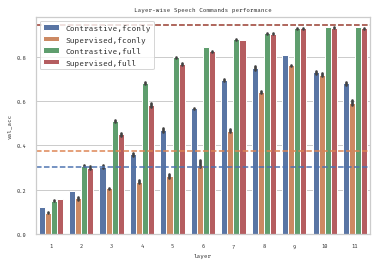

In [43]:
sns.set_theme(style="whitegrid", palette="deep", font='Fira Mono', font_scale=0.5)
colours = sns.color_palette("deep", 4)
ax = sns.barplot(x='layer', y='val_acc', hue='model_type_alt', data=df_final)
#ax.axhline(m_fconly, ls='--', color=colours[0])
#ax.axhline(m_full, ls='--', color=colours[1])
ax.axhline(contrastive_fc_val, ls='--', color=colours[0])
ax.axhline(supervised_fc_val, ls='--', color=colours[1])
ax.axhline(contrastive_full_val, ls='--', color=colours[2])
ax.axhline(supervised_full_val, ls='--', color=colours[3])

ax.legend(loc="upper left", fontsize=8)
ax.set_title("Layer-wise Speech Commands performance")
ax.figure.savefig("/home/user/Desktop/speechcommands_layerwise.png", dpi=300, bbox_inches='tight')

In [44]:
import pickle

In [45]:
with open("/media/user/nvme/contrastive_experiments/speechcommands_layerwise_data.pickle", "wb") as fd:
    pickle.dump({
        'layerwise_df': df_final,
        "supervised_full_val": supervised_full_val,
        "contrastive_full_val": contrastive_full_val,
        "supervised_fc_val": supervised_fc_val,
        "contrastive_fc_val": contrastive_fc_val
    }, fd, protocol=pickle.HIGHEST_PROTOCOL)